<a href="https://colab.research.google.com/github/robinanwyl/oud_transcriptomics/blob/main/BENG204_Project_Bulk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BENG 204 Project: Understanding Transcriptional Responses to Opioid Exposure Across Neurodevelopmental Stages in Brain Organoid Models - Bulk RNAseq Analysis

## Notebook Setup

Run this cell every time the notebook is opened to mount the drive.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


If any import statements cannot be resolved, run this cell to re-install those packages.

In [1]:
%pip install scanpy
%pip install anndata
%pip install igraph
%pip install pydeseq2
%pip install decoupler==1.8.0
%pip install gseapy==1.1.6
%pip install marsilea
%pip install adjustText

Import statements

In [2]:
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import numpy as np
import pandas as pd
import decoupler as dc
import gc
import random
from pydeseq2.dds import DeseqDataSet
from pydeseq2.ds import DeseqStats
#from pydeseq2.preprocessing import deseq2_norm
#from pydeseq2.utils import load_example_data
import matplotlib.pyplot as plt
import seaborn as sns
import gseapy as gp

# Analysis on Ho et al bulk RNA-seq data

### Test out PyDESEq2 tutorial

See what the sample data + metadata looks like

In [ ]:
sample_counts_df = load_example_data(
    modality="raw_counts",
    dataset="synthetic",
    debug=False,
)

sample_counts_df.head()

NameError: name 'load_example_data' is not defined

In [ ]:
sample_metadata = load_example_data(
    modality="metadata",
    dataset="synthetic",
    debug=False,
)
sample_metadata.head()

,condition,group
sample1,A,X
sample2,A,Y
sample3,A,X
sample4,A,Y
sample5,A,X


## DEA on Ho et al data

### Data read-in and processing

First, we read in Ho et al bulk RNA-seq data, which is in the form of a gene-by-sample matrix within a .txt file. We then transpose this matrix into a sample-by-gene matrix, from which we then remove genes that are not expressed in at least 10 cells.

In [ ]:
# Read in data
counts_df = pd.read_table("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GSE210206_counts.txt", index_col=0, header=0)
counts_df.index.name = None
counts_df.head()

In [ ]:
# Transpose
counts_df = counts_df.T
counts_df.head()

We will also drop buprenorphine samples from the counts and metadata tables since we are not considering those for our analysis.

In [ ]:
#Drop buprenorphine samples
counts_df.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
counts_df

In [ ]:
#Filtering data:
genes_to_keep = counts_df.columns[counts_df.sum(axis=0) >= 10]
counts_df = counts_df[genes_to_keep].round()
print(f"Number of genes after filtering: {counts_df.shape[1]}")
counts_df.head()

We will save the transposed and filtered `DataFrame` as a `.csv` file.

In [ ]:
#counts_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv")

### DEA on Ho dataset

Read in data

In [48]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
#Drop buprenorphine samples
ho_counts.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)

Now, we read in our sample metadata and drop buprenorphine samples:

In [45]:
metadata_Ho = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
#Drop buprenorphine samples
metadata_Ho.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
metadata_Ho

,condition,patient
OFO1003O1,oxycodone,3
OFO1003O2,oxycodone,3
OFO1003V1,PBS,3
OFO1003V2,PBS,3
OFO1004O1,oxycodone,4
OFO1004O2,oxycodone,4
OFO1004V1,PBS,4
OFO1004V2,PBS,4
OFO1005O1,oxycodone,5
OFO1005O2,oxycodone,5


In [49]:
dds = DeseqDataSet(
    counts=ho_counts,
    metadata=metadata_Ho,
    design="~condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 37.62 seconds.

Fitting dispersion trend curve...
... done in 0.60 seconds.

Fitting MAP dispersions...
... done in 34.99 seconds.

Fitting LFCs...
... done in 16.58 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



In [50]:
ds = DeseqStats(dds, contrast=["condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P        334.891714       -0.023777  0.375434 -0.063331  0.949503   
LOC729737     101.279831       -0.254941  0.326969 -0.779710  0.435561   
LOC100133331   65.896619        0.085467  0.180021  0.474763  0.634956   
MIR6723        57.464911        0.003456  0.224056  0.015425  0.987693   
LOC100288069   41.061355        0.042128  0.188033  0.224048  0.822720   
...                  ...             ...       ...       ...       ...   
TXLNGY        376.443449       -0.024936  0.203437 -0.122572  0.902446   
KDM5D         667.987542       -0.058664  0.087404 -0.671180  0.502106   
TTTY10          2.966215       -0.770596  0.671624 -1.147363  0.251232   
EIF1AY        635.048811        0.292607  0.217881  1.342965  0.179283   
RPS4Y2          0.753348        1.187694  1.495343  0.794262  0.427043   

                  padj  
WASH7P        0.99285

... done in 4.94 seconds.



In [51]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ds_df = ds_df[ds_df["padj"] <= 0.05]
ds_df.index.name = "gene_symbol"
ds_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,15.308486,3.380426,0.889235,3.801501,1.438224e-04,0.035580
TMEM72,21.251279,3.010617,0.744152,4.045704,5.216611e-05,0.018401
LOC101927023,6.331255,2.307839,0.630486,3.660412,2.518103e-04,0.049981
PTGER2,29.153726,1.750784,0.477185,3.668983,2.435177e-04,0.048963
AGPAT9,111.170314,1.396165,0.339573,4.111527,3.930511e-05,0.016364
...,...,...,...,...,...,...
CDH18,65.885447,-1.771623,0.482594,-3.671040,2.415653e-04,0.048963
CRH,59.134253,-1.826382,0.372641,-4.901185,9.526018e-07,0.001084
NWD2,107.381842,-1.899834,0.503656,-3.772086,1.618887e-04,0.037940


In [ ]:
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2.csv")

In [52]:
ds.lfc_shrink(coeff="condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.oxycodone]
          baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
BANCR     4.275449        4.775422  1.455371  3.547118  0.000389   NaN
C17orf99  1.174259        0.001878  0.431262  1.169869  0.242054   NaN
NR0B2     1.078519        0.003291  0.312917  1.429948  0.152732   NaN
BTNL3     1.029221        0.001860  0.406195  1.110193  0.266916   NaN
FABP2     2.035164        0.006175  0.210655  1.999400  0.045565   NaN
...            ...             ...       ...       ...       ...   ...
GPR110    0.000000             NaN       NaN       NaN       NaN   NaN
PAX4      0.000000             NaN       NaN       NaN       NaN   NaN
PRSS3P2   0.000000             NaN       NaN       NaN       NaN   NaN
PIP       0.000000             NaN       NaN       NaN       NaN   NaN
DEFB4A    0.000000             NaN       NaN       NaN       NaN   NaN

[20694 rows x 6 columns]


... done in 48.00 seconds.



In [53]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ds_df = ds_df[ds_df["padj"] <= 0.05]
ds_df.index.name = "gene_symbol"
ho_degs = ds_df
ho_degs.reset_index()

,gene_symbol,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,SLC22A8,15.308486,2.820128,0.930517,3.801501,1.438224e-04,0.035580
1,TMEM72,21.251279,2.586040,0.771357,4.045704,5.216611e-05,0.018401
2,LOC101927023,6.331255,1.902382,0.641543,3.660412,2.518103e-04,0.049981
3,PTGER2,29.153726,1.436707,0.501707,3.668983,2.435177e-04,0.048963
4,AGPAT9,111.170314,1.207697,0.352482,4.111527,3.930511e-05,0.016364
...,...,...,...,...,...,...,...
81,HS3ST4,82.946158,-1.376877,0.351125,-4.549464,5.378272e-06,0.003825
82,CDH18,65.885447,-1.450321,0.517678,-3.671040,2.415653e-04,0.048963
83,NWD2,107.381842,-1.577427,0.537271,-3.772086,1.618887e-04,0.037940
84,CRH,59.134253,-1.658825,0.383610,-4.901185,9.526018e-07,0.001084


In [ ]:
# ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_shrank.csv")

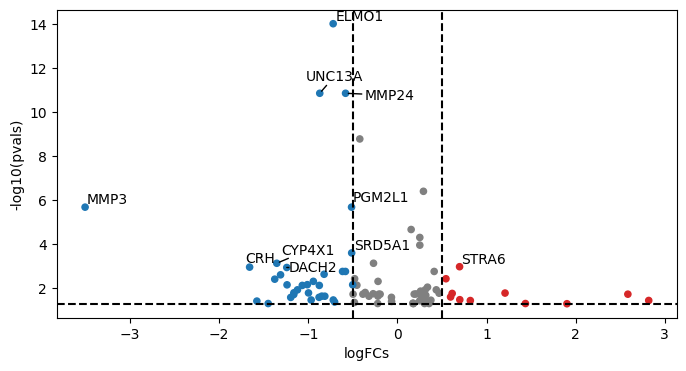

In [59]:
dc.plot_volcano_df(
    ds_df,
    x='log2FoldChange',
    y='padj',
    top=10,
    figsize=(8, 4)
)

### ORA on Ho et al dataset

In [9]:
ho_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_DEGs_2_shrank.csv", index_col=0)
ho_degs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,15.308486,2.817224,0.932700,3.793968,1.482588e-04,0.034898
TMEM72,21.251279,2.584398,0.772771,4.039238,5.362518e-05,0.017478
PTGER2,29.153726,1.435954,0.502241,3.665597,2.467621e-04,0.049201
AGPAT9,111.170314,1.207840,0.352367,4.112698,3.910624e-05,0.015413
TIMP3,1170.655814,0.818615,0.269459,3.801038,1.440911e-04,0.034395
...,...,...,...,...,...,...
HS3ST4,82.946158,-1.376833,0.351059,-4.550232,5.358670e-06,0.003633
CDH18,65.885447,-1.449823,0.518081,-3.668774,2.437159e-04,0.049173
NWD2,107.381842,-1.577144,0.537516,-3.770679,1.628038e-04,0.037286


ORA functions

In [13]:
def filter_degs_df(degs_df, padj_threshold=0.05, lfc_threshold=0.5, filter_cell_cycle_genes=True):
  """
  Given a PyDESeq2 results dataframe of DEGs, a maximum p-adj value (e.g. 0.05),
  and a positive log2FC threshold (e.g. 0.25), return a filtered dataframe.
  """
  if degs_df.empty:
    return degs_df
  # Filter DEGs by p-value and log fold change
  degs_df = degs_df[(degs_df['padj'] < padj_threshold) & (abs(degs_df['log2FoldChange']) > lfc_threshold)].copy()
  # Filter out cell cycle genes
  with open("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/GO cell cycle genes.txt", "r") as f:
    cell_cycle_genes = f.read().strip().split(",")
  degs_df = degs_df[~degs_df.index.isin(cell_cycle_genes)].copy()
  # Filter out ribosomal and mitochondrial genes
  degs_df = degs_df[~degs_df.index.str.startswith(("RPS", "RPL", "MT-"))].copy()
  return degs_df

def get_up_down_degs(degs_df):
  """
  Given a filtered PyDESeq2 results dataframe of DEGs, return lists of upregulated
  and downregulated DEGs.
  """
  if degs_df.empty:
    return [], []
  gene_list = degs_df.index.tolist()
  degs_up = degs_df[degs_df['log2FoldChange'] > 0].index.tolist()
  degs_down = degs_df[degs_df['log2FoldChange'] < 0].index.tolist()
  return degs_up, degs_down

def run_ora(degs_up, degs_down, gene_set: str):
  # Run ORA with one gene set
  up = gp.enrichr(gene_list=degs_up, gene_sets=gene_set, organism="human", outdir=None)
  down = gp.enrichr(gene_list=degs_down, gene_sets=gene_set, organism="human", outdir=None)
  up_df, down_df = up.results, down.results
  return up_df, down_df

def filter_ora_results(ora_df, padj_threshold=0.05, min_genes=1):
  # Handle empty DataFrame
  if ora_df.empty:
    return ora_df
  # Apply thresholds
  ora_df = ora_df[
      (ora_df['Adjusted P-value'] < padj_threshold) &
      (ora_df["Overlap"].apply(lambda x: int(x.split("/")[0]) >= min_genes))
      ].copy()
  if ora_df.empty:
    return ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']]
  # Round values
  ora_df.loc[:, 'Adjusted P-value'] = ora_df['Adjusted P-value'].round(4).copy()
  ora_df.loc[:, 'Odds Ratio'] = ora_df['Odds Ratio'].round(1).copy()
  ora_df.loc[:, 'Combined Score'] = ora_df['Combined Score'].round().copy()
  # Sort and filter
  ora_df.copy().sort_values('Combined Score', ascending=False, inplace=True)
  ora_df = ora_df[['Term', 'Adjusted P-value', 'Odds Ratio', 'Combined Score', 'Overlap', 'Genes']].copy()
  return ora_df

Filter DEGs

In [60]:
ho_degs_filtered = filter_degs_df(ho_degs, lfc_threshold=0.585)
ho_degs_filtered

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
gene_symbol,,,,,,
SLC22A8,15.308486,2.817224,0.932700,3.793968,1.482588e-04,3.489848e-02
TMEM72,21.251279,2.584398,0.772771,4.039238,5.362518e-05,1.747768e-02
PTGER2,29.153726,1.435954,0.502241,3.665597,2.467621e-04,4.920147e-02
AGPAT9,111.170314,1.207840,0.352367,4.112698,3.910624e-05,1.541332e-02
TIMP3,1170.655814,0.818615,0.269459,3.801038,1.440911e-04,3.439516e-02
AMPD3,43.871933,0.700268,0.224027,3.844730,1.206854e-04,3.146732e-02
STRA6,278.213291,0.697737,0.158372,4.935717,7.985702e-07,9.667263e-04
BRI3BP,43.286820,0.614781,0.178414,4.099788,4.135290e-05,1.550160e-02
MOSPD1,372.582582,0.597037,0.185040,3.933272,8.379725e-05,2.328190e-02


Get upregulated and downregulated DEGs

In [61]:
ho_up, ho_down = get_up_down_degs(ho_degs_filtered)
print(f"upregulated DEGS: {ho_up}")
print(f"downregulated DEGS: {ho_down}")

upregulated DEGS: ['SLC22A8', 'TMEM72', 'PTGER2', 'AGPAT9', 'TIMP3', 'AMPD3', 'STRA6', 'BRI3BP', 'MOSPD1']
downregulated DEGS: ['RIC3', 'KCNH1', 'NTS', 'ELMO1', 'PPP2R2C', 'EPHB6', 'ADCY1', 'UNC13A', 'FGF12', 'ZNF385D', 'SYN2', 'CACNA1I', 'TENM1', 'FRMPD4', 'ADAM20P1', 'CNTN4', 'EN2', 'NKAIN2', 'SV2B', 'DACH2', 'TFAP2B', 'CYP4X1', 'HS3ST4', 'CDH18', 'NWD2', 'CRH', 'MMP3']


Run ORA with Gene Ontology (GO) Database

In [62]:
ho_up_go, ho_down_go = run_ora(ho_up, ho_down, "GO_Biological_Process_2023")

In [63]:
filter_ora_results(ho_up_go, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [64]:
filter_ora_results(ho_down_go, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


Run ORA with GSEA Molecular Signatures (MSig) Database

In [65]:
ho_up_msig, ho_down_msig = run_ora(ho_up, ho_down, "MSigDB_Hallmark_2020")

In [66]:
filter_ora_results(ho_up_msig, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [67]:
filter_ora_results(ho_down_msig, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


Run ORA with KEGG

In [68]:
ho_up_kegg, ho_down_kegg = run_ora(ho_up, ho_down, "KEGG_2021_Human")

In [69]:
filter_ora_results(ho_up_kegg, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


In [70]:
filter_ora_results(ho_down_kegg, min_genes=2)

,Term,Adjusted P-value,Odds Ratio,Combined Score,Overlap,Genes


### GSEA on Ho et al data

In [35]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
ho_counts.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
ho_counts.head()

,WASH7P,LOC729737,LOC100133331,MIR6723,LOC100288069,FAM87B,LINC00115,LINC01128,FAM41C,LOC100130417,...,NLGN4Y-AS1,NCRNA00185,TTTY14,CD24,BCORP1,TXLNGY,KDM5D,TTTY10,EIF1AY,RPS4Y2
OFO1003O1,412,116,74,51,34,3,50,206,0,38,...,4,15,8,3522,1,226,470,3,476,0
OFO1003O2,510,110,73,64,28,5,32,242,1,50,...,2,18,13,3924,1,233,569,2,560,1
OFO1003V1,637,184,67,46,47,6,108,427,0,62,...,5,17,25,5973,3,356,761,2,526,0
OFO1003V2,686,214,74,64,49,3,90,450,0,65,...,6,35,17,5883,1,345,767,9,488,0
OFO1004O1,247,70,59,66,39,4,37,224,0,33,...,4,34,31,7829,2,420,674,2,549,0


In [32]:
ho_metadata = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
#Drop buprenorphine samples
ho_metadata.drop(['OFO1003B1', 'OFO1003B2','OFO1004B1', 'OFO1004B2', 'OFO1005B1', 'OFO1005B2'], inplace=True)
ho_metadata.head()

,condition,patient
OFO1003O1,oxycodone,3
OFO1003O2,oxycodone,3
OFO1003V1,PBS,3
OFO1003V2,PBS,3
OFO1004O1,oxycodone,4


In [36]:
ho_conditions = ho_metadata["condition"].tolist()
print(ho_conditions)

['oxycodone', 'oxycodone', 'PBS', 'PBS', 'oxycodone', 'oxycodone', 'PBS', 'PBS', 'oxycodone', 'oxycodone', 'PBS', 'PBS']


Perform GSEA with GO Database

In [40]:
gsea_ho_go = gp.gsea(
    data=ho_counts.T, # row -> genes, column-> samples
    gene_sets="GO_Biological_Process_2023",
    cls=ho_conditions,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [72]:
gsea_ho_go_res = gsea_ho_go.res2d.head()
gsea_ho_go_res.head(1)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Rac Protein Signal Transduction (GO:0016601),-0.759336,-2.026456,0.002004,0.472839,0.056,7/15,8.97%,ELMO1;CDH13;EPS8;RAC1;RAC3;WASF1;HACE1


In [42]:
gsea_ho_go_res = gsea_ho_go_res[gsea_ho_go_res["FDR q-val"] < 0.05].copy()
gsea_ho_go_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


Perform GSEA with MSig Database

In [37]:
gsea_ho_msig = gp.gsea(
    data=ho_counts.T, # row -> genes, column-> samples
    gene_sets="MSigDB_Hallmark_2020",
    cls=ho_conditions,
    permutation_num=1000,
    permutation_type='phenotype',
    outdir=None,
    method='s2n', # signal_to_noise
    threads= 16
    )

/usr/local/lib/python3.11/dist-packages/gseapy/gsea.py:173: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df = df[df_std.abs().sum(axis=1) > 0]


In [71]:
gsea_ho_msig_res = gsea_ho_msig.res2d.head()
gsea_ho_msig_res.head(1)

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes
0,gsea,Hedgehog Signaling,-0.503434,-1.495018,0.026,1.0,0.393224,18/35,29.05%,THY1;RTN1;SCG2;ACHE;PLG;DPYSL2;L1CAM;CRMP1;CDK...


In [39]:
gsea_ho_msig_res = gsea_ho_msig_res[gsea_ho_msig_res["FDR q-val"] < 0.05].copy()
gsea_ho_msig_res

,Name,Term,ES,NES,NOM p-val,FDR q-val,FWER p-val,Tag %,Gene %,Lead_genes


### Old Ho et al analysis code

Create `DeseqDataSet` with 2 treatment conditions and 3 patients

In [ ]:
dds_multi = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_Ho,
    design="~condition + patient"
)
dds_multi.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 30.73 seconds.

Fitting dispersion trend curve...
... done in 0.75 seconds.

Fitting MAP dispersions...
... done in 34.09 seconds.

Fitting LFCs...
... done in 18.38 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



Run single-factor analysis

In [ ]:
ds_multi = DeseqStats(dds_multi, contrast=["condition", "oxycodone", "PBS"])
ds_multi.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P        334.891714       -0.005950  0.194819 -0.030540  0.975636   
LOC729737     101.279831       -0.197330  0.235237 -0.838859  0.401548   
LOC100133331   65.896619        0.080895  0.171405  0.471952  0.636961   
MIR6723        57.464911        0.010519  0.223904  0.046981  0.962529   
LOC100288069   41.061355        0.033265  0.188569  0.176409  0.859973   
...                  ...             ...       ...       ...       ...   
BCORP1          1.821606       -0.152321  0.829046 -0.183730  0.854225   
TXLNGY        376.443449       -0.046179  0.148836 -0.310269  0.756356   
KDM5D         667.987542       -0.062632  0.075228 -0.832556  0.405095   
TTTY10          2.966215       -0.781096  0.701997 -1.112677  0.265847   
EIF1AY        635.048811        0.284855  0.117343  2.427549  0.015201   

                  padj  
WASH7P        0.98883

... done in 6.90 seconds.



In [ ]:
ds_df2 = ds_multi.results_df
ds_df2.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df2 = ds_df2[(ds_df2["padj"] <= 0.05) & (ds_df2["padj"].notna())]
DEGs_df2

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SLC22A8,15.308486,3.743952,0.869002,4.308335,1.644878e-05,5.639242e-04
CLCA1,8.164331,3.625512,1.069900,3.388644,7.023904e-04,9.150213e-03
ATP13A5,58.445274,3.604253,0.758466,4.752029,2.013856e-06,1.122810e-04
SI,44.680029,3.200747,0.986351,3.245039,1.174345e-03,1.330889e-02
TMEM72,21.251279,3.126735,0.735809,4.249382,2.143608e-05,6.919299e-04
...,...,...,...,...,...,...
GABRA4,25.097453,-1.944898,0.492814,-3.946515,7.929703e-05,1.854632e-03
NWD2,107.381842,-1.962085,0.458146,-4.282662,1.846703e-05,6.152828e-04
CNTNAP4,260.117923,-2.122032,0.596526,-3.557314,3.746661e-04,5.787403e-03
AGTR2,16.688500,-2.399409,0.834080,-2.876713,4.018413e-03,3.176177e-02


Now, we create our `DeseqDataSet` object and then fit said object with dispersions and LFCs for differential expression analysis.

In [ ]:
dds = DeseqDataSet(
    counts=counts_df,
    metadata=metadata_Ho,
    design="~condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 29.10 seconds.

Fitting dispersion trend curve...
... done in 0.81 seconds.

Fitting MAP dispersions...
... done in 36.22 seconds.

Fitting LFCs...
... done in 15.90 seconds.

Calculating cook's distance...
... done in 0.03 seconds.

Replacing 0 outlier genes.



In [ ]:
print(dds)

AnnData object with n_obs × n_vars = 12 × 20060
    obs: 'condition', 'patient'
    uns: 'trend_coeffs', 'disp_function_type', '_squared_logres', 'prior_disp_var'
    obsm: 'design_matrix', 'size_factors', '_mu_LFC', '_hat_diagonals', 'replaceable'
    varm: '_normed_means', 'non_zero', '_MoM_dispersions', 'genewise_dispersions', '_genewise_converged', 'fitted_dispersions', 'MAP_dispersions', '_MAP_converged', 'dispersions', '_outlier_genes', 'LFC', '_LFC_converged', 'replaced', 'refitted', '_pvalue_cooks_outlier'
    layers: 'normed_counts', '_mu_hat', 'cooks'


We will now perform our statistical analyses upon the aforementioned `DeseqDataSet` by first creating a `DeseqStats` object & then running the `summary()` method.

In [ ]:
ds = DeseqStats(dds, contrast=["condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 7.15 seconds.



Log2 fold change & Wald test p-value: condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P        334.891714       -0.023778  0.375270 -0.063361  0.949479   
LOC729737     101.279831       -0.254944  0.326872 -0.779950  0.435421   
LOC100133331   65.896619        0.085462  0.179679  0.475637  0.634333   
MIR6723        57.464911        0.003457  0.223834  0.015447  0.987676   
LOC100288069   41.061355        0.042135  0.187707  0.224474  0.822388   
...                  ...             ...       ...       ...       ...   
BCORP1          1.821606       -0.108533  0.780496 -0.139057  0.889405   
TXLNGY        376.443449       -0.024928  0.203087 -0.122747  0.902307   
KDM5D         667.987542       -0.058654  0.086985 -0.674295  0.500124   
TTTY10          2.966215       -0.770665  0.672726 -1.145585  0.251967   
EIF1AY        635.048811        0.292606  0.217535  1.345098  0.178594   

                  padj  
WASH7P        0.99259

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
BANCR,4.275449,5.127499,1.447940,3.541237,0.000398,NaN
C17orf99,1.174259,3.767533,3.220475,1.169869,0.242054,NaN
NR0B2,1.078519,3.650263,2.572710,1.418840,0.155946,NaN
BTNL3,1.029221,3.579031,3.223792,1.110193,0.266916,NaN
FABP2,2.035164,3.499663,1.758728,1.989884,0.046604,NaN
...,...,...,...,...,...,...
HOTAIR,5.260556,-3.724658,1.622641,-2.295430,0.021709,NaN
HOXD11,1.556911,-4.035155,2.547932,-1.583698,0.113262,NaN
LOC100128682,1.800643,-4.244179,3.211029,-1.321751,NaN,NaN
HOXD10,1.828149,-4.261860,2.212821,-1.925985,0.054106,NaN


In [ ]:
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df = ds_df[ds_df["padj"] <= 0.05]
DEGs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SLC22A8,15.308486,3.380356,0.890982,3.793968,1.482588e-04,0.034898
TMEM72,21.251279,3.010628,0.745346,4.039238,5.362518e-05,0.017478
PTGER2,29.153726,1.750756,0.477618,3.665597,2.467621e-04,0.049201
AGPAT9,111.170314,1.396165,0.339477,4.112698,3.910624e-05,0.015413
TIMP3,1170.655814,0.976660,0.256946,3.801038,1.440911e-04,0.034395
...,...,...,...,...,...,...
CDH18,65.885447,-1.771631,0.482894,-3.668774,2.437159e-04,0.049173
CRH,59.134253,-1.826384,0.372707,-4.900326,9.567767e-07,0.001070
NWD2,107.381842,-1.899839,0.503845,-3.770679,1.628038e-04,0.037286
EIF4E1B,6.738918,-1.979831,0.507029,-3.904772,9.431416e-05,0.025082


Here, we perform LFC shrinkage to improve the accuracy of our estimates via shrinking LFC estimates of genes with low information (e.g. low counts or high dispersions) towards 0.

In [ ]:
ds.lfc_shrink(coeff="condition[T.oxycodone]")

Fitting MAP LFCs...


Shrunk log2 fold change & Wald test p-value: condition[T.oxycodone]
              baseMean  log2FoldChange     lfcSE      stat    pvalue  padj
BANCR         4.275449        4.771582  1.457924  3.541237  0.000398   NaN
C17orf99      1.174259        0.001895  0.433144  1.169869  0.242054   NaN
NR0B2         1.078519        0.003255  0.317336  1.418840  0.155946   NaN
BTNL3         1.029221        0.001877  0.407968  1.110193  0.266916   NaN
FABP2         2.035164        0.006153  0.212135  1.989884  0.046604   NaN
...                ...             ...       ...       ...       ...   ...
HOTAIR        5.260556       -0.006415  0.080750 -2.295430  0.021709   NaN
HOXD11        1.556911       -0.003391  0.078339 -1.583698  0.113262   NaN
LOC100128682  1.800643       -0.001926  0.077410 -1.321751       NaN   NaN
HOXD10        1.828149       -0.005075  0.078985 -1.925985  0.054106   NaN
HOXC12        4.877027       -0.002199  0.076889 -1.849052  0.064450   NaN

[20060 rows x 6 columns]


... done in 44.74 seconds.



Here, we view the results of the above Wald tests.

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
BANCR,4.275449,4.771582,1.457924,3.541237,3.982550e-04,NaN
SLC22A8,15.308486,2.817224,0.932700,3.793968,1.482588e-04,0.034898
TMEM72,21.251279,2.584398,0.772771,4.039238,5.362518e-05,0.017478
SI,44.680029,2.509417,0.977759,3.495044,4.739834e-04,0.071089
LOC339059,1.977012,2.454178,1.148217,2.814467,4.885819e-03,NaN
...,...,...,...,...,...,...
CDH18,65.885447,-1.449823,0.518081,-3.668774,2.437159e-04,0.049173
NWD2,107.381842,-1.577144,0.537516,-3.770679,1.628038e-04,0.037286
CRH,59.134253,-1.658769,0.383681,-4.900326,9.567767e-07,0.001070
PWRN1,2.562178,-2.044528,0.927181,-3.080838,2.064192e-03,NaN


We want to view genes that demonstrate the highest or lowest log2fold changes, but with padj <= 0.05.

---



In [ ]:
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
DEGs_df = ds_df[ds_df["padj"] <= 0.05]
DEGs_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SLC22A8,15.308486,2.817224,0.932700,3.793968,1.482588e-04,0.034898
TMEM72,21.251279,2.584398,0.772771,4.039238,5.362518e-05,0.017478
PTGER2,29.153726,1.435954,0.502241,3.665597,2.467621e-04,0.049201
AGPAT9,111.170314,1.207840,0.352367,4.112698,3.910624e-05,0.015413
TIMP3,1170.655814,0.818615,0.269459,3.801038,1.440911e-04,0.034395
...,...,...,...,...,...,...
HS3ST4,82.946158,-1.376833,0.351059,-4.550232,5.358670e-06,0.003633
CDH18,65.885447,-1.449823,0.518081,-3.668774,2.437159e-04,0.049173
NWD2,107.381842,-1.577144,0.537516,-3.770679,1.628038e-04,0.037286
CRH,59.134253,-1.658769,0.383681,-4.900326,9.567767e-07,0.001070


Now, we export both our results & the differentially expressed genes as .csv files.

In [ ]:
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")

### (Old) Visualizing Ho et al DEGs

Read in results of statistical analysis

In [ ]:
ds_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")
DEGs_df = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
ds_df.head(10)

,Unnamed: 0,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,BANCR,4.275449,4.771582,1.457924,3.541237,0.000398,NaN
1,SLC22A8,15.308486,2.817224,0.932700,3.793968,0.000148,0.034898
2,TMEM72,21.251279,2.584398,0.772771,4.039238,0.000054,0.017478
3,SI,44.680029,2.509417,0.977759,3.495044,0.000474,0.071089
4,LOC339059,1.977012,2.454178,1.148217,2.814467,0.004886,NaN
5,ATP13A5,58.445274,2.320139,0.970841,3.375703,0.000736,0.088483
6,CLCA1,8.164331,2.269375,1.179157,3.065294,0.002175,0.154246
7,ANKUB1,4.405699,2.121457,0.946941,3.144473,0.001664,NaN
8,LINC00305,3.977777,2.078843,0.852823,3.235487,0.001214,NaN
9,F5,155.059114,1.929334,0.739835,3.510279,0.000448,0.068969


We will add a column to the results `DataFrame` indicating whether a gene is non-significant (ns), significant and increases in expression (up), or significant and decreases in expression (down).

In [ ]:
ds_df["significance"] = np.where(ds_df["padj"] > 0.05, "ns", np.where(abs(ds_df["log2FoldChange"]) >= 0.25, "up", "down"))

We will save the results DataFrame:


In [ ]:
ds_df.to_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_results.csv")

We now plot the log2 fold-change versus mean expression between both conditions.

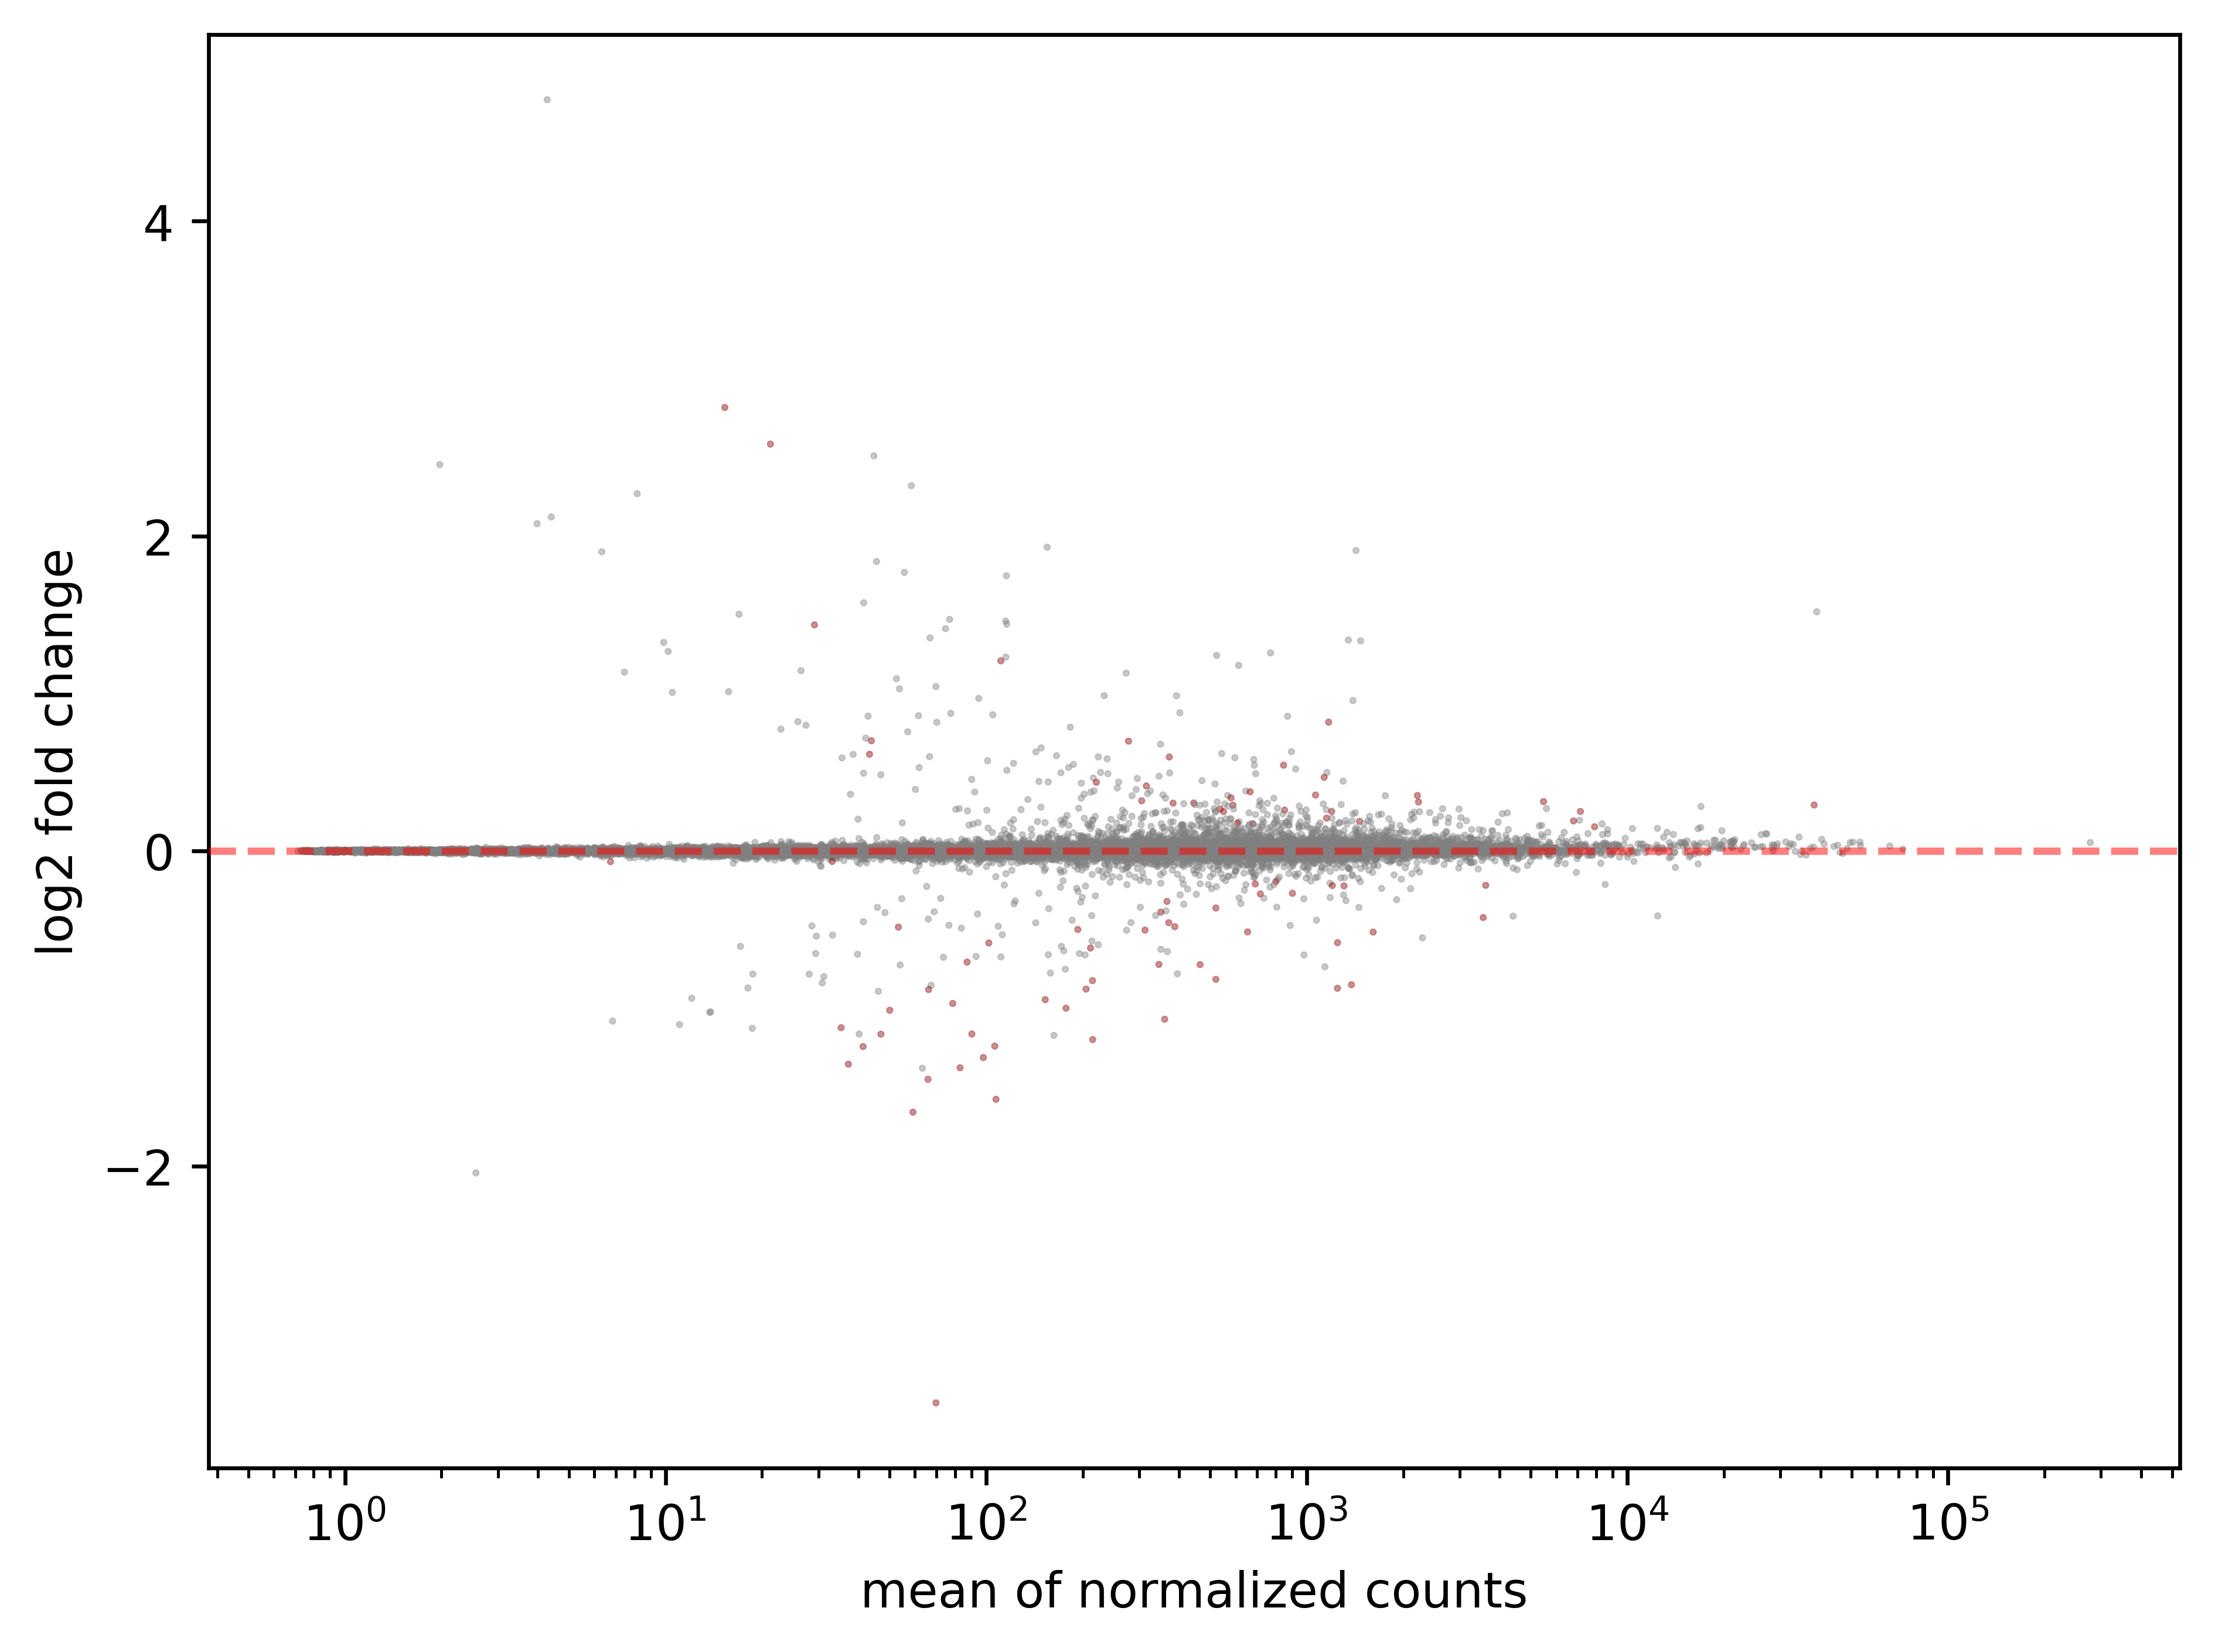

In [ ]:
ds.plot_MA(save_path="/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/")


We now generate a volcano plot for the Ho et al DEGs.

KeyError: 'gene_symbol'

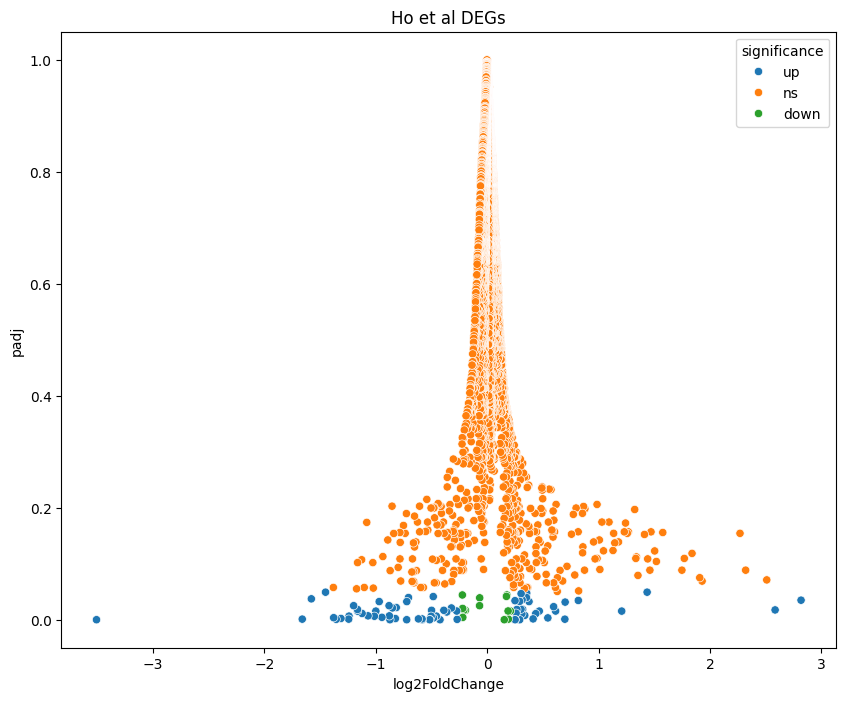

In [ ]:
plt.figure(figsize=(10, 8))
volcano = sns.scatterplot(ds_df, x = 'log2FoldChange', y = 'padj', hue='significance')
volcano.set_title("Ho et al DEGs")
DEGs = ["DACH2", "RIC3", "SRI", "VKORC1", "ICT1", "MOSPD1", "TIMP3", "AGPAT9", "PTGER2", "TMEM72"]
for i, row in DEGs_df.iterrows():
    if row['gene_symbol'] in DEGs:
      if i % 2 == 1:
        volcano.text(row['log2FoldChange']-0.05, row['padj']+0.01, row['gene_symbol'], fontsize=9)
      else:
        volcano.text(row['log2FoldChange']-0.05, row['padj']-0.03, row['gene_symbol'], fontsize=9)

Save the volcano plot:

In [ ]:
volcano.figure.savefig("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_volcano.png", dpi=300)

Now, we generate a heatmap of the changes in normalized exprerssion levels between conditions. To do so, we must first explicitly normalize the counts data via scanpy's scanpy.pp.normalize_total method & saving the results as a dataframe.

In [ ]:
#Pulling out the read counts (saving it as a numpy matrix temporarily):
RawReadsFromDDS = dds.X
#Normalizing the read counts:
NormalizedReads = sc.pp.normalize_total(RawReadsFromDDS)
NormalizedReads

In [ ]:
#Then, we use this new LFC dataframe to initialize a seaborn (denoted sns) heatmap object.
LFC_heatmap = sns.heatmap(LFC_matrix_df, cmap ='autumn', cbar = True)

### (Old) ORA on Ho et al data

To perform ORA on the Ho et al data, we ideally want a larger list of DEGs. Previously we performed LFC shrinkage for further visualization and comparison, but this may have narrowed down the DEG list too much. We will repeat the analysis without LFC shrinkage.

In [ ]:
ho_counts = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_counts_filtered.csv", index_col=0)
ho_metadata = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Data/Ho_et_al_metadata.csv", index_col=0)
dds = DeseqDataSet(
    counts=ho_counts,
    metadata=ho_metadata,
    design="~Condition"
)
dds.deseq2()

Fitting size factors...
... done in 0.02 seconds.



Using None as control genes, passed at DeseqDataSet initialization


Fitting dispersions...
... done in 29.80 seconds.

Fitting dispersion trend curve...
... done in 0.84 seconds.

Fitting MAP dispersions...
... done in 39.48 seconds.

Fitting LFCs...
... done in 17.08 seconds.

Calculating cook's distance...
... done in 0.05 seconds.

Replacing 0 outlier genes.



In [ ]:
ds = DeseqStats(dds, contrast=["Condition", "oxycodone", "PBS"])
ds.summary()

Running Wald tests...
... done in 7.45 seconds.



Log2 fold change & Wald test p-value: Condition oxycodone vs PBS
                baseMean  log2FoldChange     lfcSE      stat    pvalue  \
WASH7P        344.202941       -0.021586  0.327446 -0.065923  0.947439   
LOC729737     102.130186       -0.250510  0.316119 -0.792454  0.428096   
LOC100133331   66.223814        0.089953  0.174544  0.515359  0.606302   
MIR6723        65.966132        0.007637  0.233102  0.032763  0.973864   
LOC100288069   41.854978        0.044645  0.191099  0.233622  0.815279   
...                  ...             ...       ...       ...       ...   
TXLNGY        378.969377       -0.020204  0.186730 -0.108199  0.913838   
KDM5D         694.759371       -0.054766  0.081218 -0.674307  0.500116   
TTTY10          3.112367       -0.767770  0.648624 -1.183692  0.236535   
EIF1AY        607.783994        0.298369  0.239899  1.243727  0.213600   
RPS4Y2          0.929605        1.184722  1.365490  0.867617  0.385604   

                  padj  
WASH7P        0.99052

In [ ]:
ds_df = ds.results_df
ds_df.sort_values('log2FoldChange', ascending = False, inplace=True)
ho_degs = ds_df[ds_df["padj"] <= 0.05]
ho_degs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
TMEM72,28.752807,2.997913,0.667681,4.490036,7.121108e-06,0.015206
PTGER2,33.517680,1.752511,0.411904,4.254655,2.093713e-05,0.035767
AGPAT9,114.833434,1.391940,0.308686,4.509245,6.505866e-06,0.015206
TIMP3,1521.537448,0.974865,0.210550,4.630080,3.655247e-06,0.013992
MOSPD1,400.777753,0.699858,0.153195,4.568405,4.914501e-06,0.013992
ICT1,336.556565,0.456857,0.094519,4.833475,1.341704e-06,0.007640
VKORC1,1213.250268,0.270438,0.044918,6.020707,1.736570e-09,0.000030
SRI,1236.440551,0.236830,0.056903,4.161965,3.155211e-05,0.049000
RIC3,238.807008,-0.678952,0.148375,-4.575911,4.741512e-06,0.013992
DACH2,48.335752,-1.366387,0.310402,-4.401986,1.072646e-05,0.020360


The DEGs from the DEA performed without LFC shrinkage are the same, so we will proceed with ORA.

In [ ]:
# Read in DEGs
ho_degs = pd.read_csv("/content/drive/My Drive/BENG204_Project/BENG204_Project_Results/Ho_et_al_DEGs.csv")
# Get lists of upregulated and downregulated genes
ho_degs_up = ho_degs[ho_degs['log2FoldChange'] > 0]
ho_degs_up = ho_degs_up['gene_symbol'].tolist()
ho_degs_down = ho_degs[ho_degs['log2FoldChange'] < 0]
ho_degs_down = ho_degs_down['gene_symbol'].tolist()

We will start with ORA compared to the GO database:

In [ ]:
# Upregulated genes
ho_ora_up_go = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets=["GO_Biological_Process_2023"],
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_go = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets=["GO_Biological_Process_2023"],
    organism="human",
    outdir=None
)
ho_ora_up_go_df = ho_ora_up_go.results
ho_ora_down_go_df = ho_ora_down_go.results

In [ ]:
ho_ora_up_go_df_p = ho_ora_up_go_df[ho_ora_up_go_df['Adjusted P-value'] < 0.05]
ho_ora_up_go_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_go_df_p['Adjusted P-value'].round(4)
ho_ora_up_go_df_p.loc[:, 'Combined Score'] = ho_ora_up_go_df_p['Combined Score'].round()
ho_ora_up_go_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Positive Regulation Of Extrinsic Apoptotic Sig...,0.0160,4437.0,1/5,TIMP3
2,Intracellular Sequestering Of Iron Ion (GO:000...,0.0160,3445.0,1/6,SRI
3,Negative Regulation Of Heart Rate (GO:0010459),0.0160,3445.0,1/6,SRI
4,Regulation Of Relaxation Of Muscle (GO:1901077),0.0160,3445.0,1/6,SRI
5,Cellular Response To Prostaglandin E Stimulus ...,0.0160,3445.0,1/6,PTGER2
1,Negative Regulation Of Membrane Protein Ectodo...,0.0160,3445.0,1/6,TIMP3
6,Vitamin K Metabolic Process (GO:0042373),0.0160,2343.0,1/8,VKORC1
7,Regulation Of High Voltage-Gated Calcium Chann...,0.0160,2008.0,1/9,SRI
8,Cellular Response To Prostaglandin Stimulus (G...,0.0160,2008.0,1/9,PTGER2
9,Quinone Metabolic Process (GO:1901661),0.0160,2008.0,1/9,VKORC1


In [ ]:
ho_ora_down_go_df_p = ho_ora_down_go_df[ho_ora_down_go_df['Adjusted P-value'] < 0.05]
ho_ora_down_go_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_go_df_p['Adjusted P-value'].round(4)
ho_ora_down_go_df_p.loc[:, 'Combined Score'] = ho_ora_down_go_df_p['Combined Score'].round()
ho_ora_down_go_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Regulation Of Hydrogen Peroxide Metabolic Proc...,0.0080,17983.0,1/5,MMP3
1,Cellular Response To Nitric Oxide (GO:0071732),0.0080,11427.0,1/7,MMP3
2,Regulation Of Oxidative Stress-Induced Cell De...,0.0080,11427.0,1/7,MMP3
3,Cellular Response To Reactive Nitrogen Species...,0.0080,11427.0,1/7,MMP3
4,Cellular Response To UV-A (GO:0071492),0.0080,7221.0,1/10,MMP3
5,Response To Nitric Oxide (GO:0071731),0.0080,6403.0,1/11,MMP3
6,Positive Regulation Of Protein Localization To...,0.0080,5742.0,1/12,RIC3
7,Response To UV-A (GO:0070141),0.0080,5197.0,1/13,MMP3
8,"Synaptic Transmission, Cholinergic (GO:0007271)",0.0085,4018.0,1/16,RIC3
9,Cellular Response To Inorganic Substance (GO:0...,0.0085,3476.0,1/18,MMP3


Next, we will perform ORA with MSigDB:

In [ ]:
# Upregulated genes
ho_ora_up_msig = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets="MSigDB_Hallmark_2020",
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_msig = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets="MSigDB_Hallmark_2020",
    organism="human",
    outdir=None
)
ho_ora_up_msig_df = ho_ora_up_msig.results
ho_ora_down_msig_df = ho_ora_down_msig.results

In [ ]:
ho_ora_up_msig_df_p = ho_ora_up_msig_df[ho_ora_up_msig_df['Adjusted P-value'] < 0.05]
ho_ora_up_msig_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_msig_df_p['Adjusted P-value'].round(4)
ho_ora_up_msig_df_p.loc[:, 'Combined Score'] = ho_ora_up_msig_df_p['Combined Score'].round()
ho_ora_up_msig_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Inflammatory Response,0.0214,197.0,2/200,PTGER2;SRI


In [ ]:
ho_ora_down_msig_df_p = ho_ora_down_msig_df[ho_ora_down_msig_df['Adjusted P-value'] < 0.05]
ho_ora_down_msig_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_msig_df_p['Adjusted P-value'].round(4)
ho_ora_down_msig_df_p.loc[:, 'Combined Score'] = ho_ora_down_msig_df_p['Combined Score'].round()
ho_ora_down_msig_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Coagulation,0.0297,282.0,1/138,MMP3
1,Epithelial Mesenchymal Transition,0.0297,175.0,1/200,MMP3


In [ ]:
# Upregulated genes
ho_ora_up_kegg = gp.enrichr(
    gene_list=ho_degs_up,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None
)
# Downregulated genes
ho_ora_down_kegg = gp.enrichr(
    gene_list=ho_degs_down,
    gene_sets="KEGG_2021_Human",
    organism="human",
    outdir=None
)
ho_ora_up_kegg_df = ho_ora_up_kegg.results
ho_ora_down_kegg_df = ho_ora_down_kegg.results

In [ ]:
ho_ora_up_kegg_df_p = ho_ora_up_kegg_df[ho_ora_up_kegg_df['Adjusted P-value'] < 0.05]
ho_ora_up_kegg_df_p.loc[:, 'Adjusted P-value'] = ho_ora_up_kegg_df_p['Adjusted P-value'].round(4)
ho_ora_up_kegg_df_p.loc[:, 'Combined Score'] = ho_ora_up_kegg_df_p['Combined Score'].round()
ho_ora_up_kegg_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Ubiquinone and other terpenoid-quinone biosynt...,0.0395,1549.0,1/11,VKORC1


In [ ]:
ho_ora_down_kegg_df_p = ho_ora_down_kegg_df[ho_ora_down_kegg_df['Adjusted P-value'] < 0.05]
ho_ora_down_kegg_df_p.loc[:, 'Adjusted P-value'] = ho_ora_down_kegg_df_p['Adjusted P-value'].round(4)
ho_ora_down_kegg_df_p.loc[:, 'Combined Score'] = ho_ora_down_kegg_df_p['Combined Score'].round()
ho_ora_down_kegg_df_p[['Term', 'Adjusted P-value', 'Combined Score', 'Overlap', 'Genes']].sort_values('Combined Score', ascending=False)

,Term,Adjusted P-value,Combined Score,Overlap,Genes
0,Rheumatoid arthritis,0.0292,463.0,1/93,MMP3
1,IL-17 signaling pathway,0.0292,457.0,1/94,MMP3
2,Prostate cancer,0.0292,439.0,1/97,MMP3
3,TNF signaling pathway,0.0292,367.0,1/112,MMP3
4,Transcriptional misregulation in cancer,0.0344,184.0,1/192,MMP3
5,Lipid and atherosclerosis,0.0344,159.0,1/215,MMP3
6,Coronavirus disease,0.0344,144.0,1/232,MMP3
